# Comparison of our numerical results with those from PRB 86, 115423 (2012)
This notebook contains the codes for comparing out method to compute the thermal emission spectrum with the results presented in the paper PRB 86, 115423 (2012)

Last time edited: 03.07.2025

## Necessary libraries:
- Numpy for vector functions, as well for general math functions
- Matplotlib for plotting
- Treams to compute T-matrices
- Scipy for computing the singular value decomposition and for computing numerical integrals

For T-matrices, the notebook is set by default for the helicity basis. More information in https://tfp-photonics.github.io/treams/treams.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import treams as trm
import numpy.linalg as lg
from scipy.optimize import linear_sum_assignment
from timeit import default_timer as timer
%pylab inline

trm.config.POLTYPE = 'helicity'

Populating the interactive namespace from numpy and matplotlib


# General parameters and physical constants 

In [36]:
hbar = 1.05457182e-34 #Dirac's constant in Js
Kb = 1.380649e-23 #Boltzmann's constant in J/K
c0 = 299792458 #Speed of light in vaccuum in m/s

fvals = np.logspace(np.log10(1e11), np.log10(1e14), 300) #Range of frequencies
kvals = 2*np.pi*fvals/c0 #Range of wave vectors

mur = 1 #Magnetic permeability of the sphere
radii = np.logspace(np.log10(1e-8), np.log10(5e-6), 80) #Array of radii
eps_bg = 1 #Dielectric constant of the surrounding medium
mu_bg = 1 #Magnetic permeability of the surrounding medium

## Dielectric function of the sphere
For the dielectric function of the sphere, we use the Drude model

$$ \epsilon(\omega) = 1 - \frac{\omega_p^2}{\omega(\omega+ i\omega_t)},$$
with $\omega_t = 2.67\times 10^{-2}$ eV $ = 6.45$ THz, and $\omega_p = 9.03$ eV $ = 2183.44$ THz.

In [3]:
plfreq = 2183.44e12 #Resonance frequency 
freqdam = 6.45e12 #Damping factor

def epsr(f):
    return 1 - (plfreq)**2/(f*(f+ 1j*freqdam))

## Functions for calculating the T and Q matrices and SVD
- The function `Tmatrix` computes the T-matrix up to order `jmax` for a sphere of radius `r` when this is illuminated with light of frequency `f` (in Hz). This function returns a matrix such that its dimension depends on `jmax`, i.e., the maximum multipolar order.
- The function `Tmatrices` computes a T-matrix up to order `jmax` at every frequency in the array `fvals` for a sphere of radius `r`. It returns an array composed of matrices.
- The function `Q-matrices` compute a Q-matrix for every T-matrix in the array `Tmats`
- The function `SVD` computes the singular value decomposition of the Q-matrix for every matrix in the array `Qmats`. The function returns an array with two elements: the first one is an matrix whose rows contain the singular values for a single frequency. The second element is matrix whose rows contain the singular vectors for each single frequency. More information can be read below on how to access to the singular values and vectors. 
- `TestAccuracy` is a test function to check which value of jmax suits best for describing the system. A value for the radius `r` of the sphere is provided, and the idea is to compare the trace of the Q-matrix for all $j < j_\text{max} = 30$, for the highest frequency value in the array `fvals` that is: $$\frac{\text{Tr}\{\mathbf{Q}(j)\}}{\text{Tr}\{\mathbf{Q}(j_\text{max})\}}$$. As close to 1 this number is for `jmax=30`, more accurate the computation will be.
***

In [5]:
def Tmatrix(f,r,jmax):
    kvec = 2*np.pi*f/c0
    materials = [trm.Material(epsr(f),mur,0), trm.Material(eps_bg,mu_bg,0)]
    sph = trm.TMatrix.sphere(jmax, kvec, r, materials) 
    return sph.__array__()

def Tmatrices(r,jmax):
    Ts = []
    for f in fvals:
        materials = [trm.Material(epsr(f),mur,0), trm.Material(eps_bg,mu_bg,0)]
        sph = trm.TMatrix.sphere(jmax, 2*np.pi*f/c0, r, materials) 
        Ts.append(sph.__array__())
    return Ts

def Qmatrices(Tmats):
    Qs = []
    for t in Tmats:
        Qs.append(-2*t.T.conjugate() - 2*t - 4*np.matmul(t.T.conjugate(), t))
    return Qs

def SVD(Qmats):
    K, gamma, G = lg.svd(Qmats[0])
    val1, vec1 = gamma, G
    sorted_levels = [val1]
    sorted_vecs = [vec1]
        
    for f in range(len(fvals[1:])):
        K, gamma, G = lg.svd(Qmats[f])
        val2, vec2 = gamma, G
        ov_matrix = np.abs(vec1 @ vec2.T.conj())
        optimal = linear_sum_assignment(-ov_matrix)[1]
        sorted_levels.append(val2[optimal])
        vec1 = vec2[optimal,:]
        sorted_vecs.append(vec1)

    return [sorted_levels, sorted_vecs]

def TestAccuracy(r):
    acc = []
    f = max(fvals)
    for j in range(1,30): #This test is set for jmax = 15
        tm = Tmatrix(f, r, j)
        acc.append(np.trace(tm@tm.T.conj()))
    return acc/acc[-1]

In [6]:
TestAccuracy(5e-6)

array([0.02569872+3.87453834e-20j, 0.06852798-2.09899103e-19j,
       0.12847915-3.72439382e-19j, 0.20570692-1.45033581e-18j,
       0.29945769-9.29019886e-19j, 0.41088624-1.26149290e-18j,
       0.54287472-1.02459244e-18j, 0.68815355-1.52836873e-18j,
       0.82877447-1.10588516e-18j, 0.94282683-1.94571318e-19j,
       0.9932675 -7.39874884e-20j, 0.99960955+6.51217451e-20j,
       0.99998478+2.84094341e-20j, 0.99999958-2.93827729e-20j,
       0.99999999-3.97565685e-20j, 1.        +6.49331875e-20j,
       1.        -1.45402125e-20j, 1.        +6.49331874e-20j,
       1.        +8.39828769e-20j, 1.        +2.93857353e-20j,
       1.        +5.65570594e-20j, 1.        +6.49331874e-20j,
       1.        +6.49331874e-20j, 1.        +6.49331874e-20j,
       1.        +4.58790110e-20j, 1.        +3.04415827e-20j,
       1.        +6.49331874e-20j, 1.        +6.49331874e-20j,
       1.        +0.00000000e+00j])

***
## Functions for computing the emission thermal spectrum
- `PW2SW` is the function that transforms a vector from the plane wave basis to the multipolar basis. It takes as arguments the polar angle `theta` and azimuthal angle `phi`, and the maximum multipolar order `jmax`. Since the library Treams handles helicity values of 0 for -1 helicity, conversion to the value 1 is necessary. The function `SphericalWaveBasis.default(jmax)` provides the values of $j$ , $m$ and $\lambda$ for each element of the array given the value of `jmax`, which is necessary to know the corresponding values to transform. Since states with opposite polarization are orthogonal, only elements with the same polarization as the one of interest (`lam=1`) are converted. The function returns a vector with the coefficients, whose dimension is $2j_\text{max}(j_\text{max} + 2).$
- The function `prodDs` calculates the product between the elements of the Wigner matrices $D^j_{m1}$ and the vectors $|s\rangle$ (Eq. (11)). The function takes as parameters the vector of coefficients in the multipolar basis obtained from the PW2SW function, and a singular vector s. Since the library Treams handles helicity values of 0 for -1 helicity, conversion to the value -1 is necessary. The function returns the squared scalar product value between the vectors $D$ and $|s\rangle$.
- The function `KirchhoffsLaw` computes the thermal angular spectrum (Eq. (18)). This function uses the coefficients given by `PW2SW` by considering the direction $-\vec{k}$. This function takes as arguments the angles `theta` and `phi`, the helicity `lam=1` of the emitted radiation, the singular values `vals` and vectors `vecs`, respectively, the temperature `T`, and the maximum multipolar order `jmax`, and returns the value of the angular thermal spectrum multiplied by `k`, for having the correct units of photon density.

***

In [7]:
def PW2SW(theta, phi, jmax):
    coeff = []
    indices = trm.SphericalWaveBasis.default(jmax)
    for count in range(len(indices)):
        j, m, la = indices[count][1:]
        if la != 1:
            coeff.append(0.0)
        else: 
            coeff.append(np.sqrt((2*j+1)/(4*np.pi))*trm.special.cython_special.wignerd(j,m,la,phi,theta,0))
    return coeff

def prodDs(Dvec, vec, jmax):
    indices = trm.SphericalWaveBasis.default(jmax)
    summ = 0
    for count in range(len(indices)): #Loop over all possible combinacions of j,m and λ
        j, m, la = indices[count][1:]
        if la == 1:
            summ += np.conjugate(Dvec[count])*vec[count]
    return abs(summ)**2

def KirchhoffsLaw(kvals, vals, vecs, jmax, T, D):
    beta = (hbar*c0)/(Kb*T)
    Expvals = []
    for f in range(len(kvals)): #loop over the frequencies
        Expval = 0
        for i in range(len(vals[0])): #loop over the modes
            Expval += c0*vals[f][i]/(2*np.pi*kvals[f]*(np.exp(beta*kvals[f]) -1)) * prodDs(D, vecs[f][i], jmax)
        Expvals.append(Expval)
    return 8*np.pi*kvals*Expvals
    #A factor of 4π accounts for the integration over the solid angle
    #A factor of 2 accounts for the contribution of both helicities

## Code for computing the radiation rate

The radiation rate is the energy emitted per unit time, therefore it is defined as the product of the number of photons times the energy of each photon. From Eq. (21) in the paper we have:

$$E = \int dk (\hbar ck)\mathcal{I}(k)$$

#### Note : Because we're dealing with a spherical symmetric problem, the values of $\theta$ and $\phi$ do not matter. They were set both to $\pi/4$

In [ ]:
emph = []

Dvec = PW2SW(np.pi-np.pi/4, np.pi/4 + np.pi, 16) #Since theta and phi are fixed, we compute the D vector 

for r in radii:
    Tmats = Tmatrices(r, 16) #Computing T-matrices for a given radius r
    Qmats = Qmatrices(Tmats) # Computing Q-matrices from the T-matrices array
    vals, vecs = SVD(Qmats) # Computing the SVD for the array of Q-matrices
    aspec = np.array(KirchhoffsLaw(kvals, vals, vecs, 16, 300, Dvec)) # Computing the thermal angular spectrum
    #This result is already integrated over the solid angle and accounts for both helicities
    integral = np.trapz(aspec*kvals*hbar*c0, kvals) # Integral over the wavenumbers of hbar c0 k
    emph.append(integral) 
    
emph = np.array(emph)

Here I have the data extracted from the plot (Fig 2, for gold)

In [10]:
x = np.array([0.010241479364986743, 0.010742072592206975, 0.011267134313695273, 0.011677705348628612, 0.012248499859720664,
              0.012694831564284944, 0.013157427463875625, 0.01380054930607504, 0.014303437232453678, 0.01482465024581896,
              0.01573588567649025, 0.01573588567649025, 0.016703132547319786, 0.017311789746714854, 0.017311789746714854,
              0.018596450216023536, 0.018596450216023536, 0.01973952907728264, 0.01973952907728264, 0.02120434542841505, 
              0.021977025491086016, 0.022777861786226646, 0.022777861786226646, 0.023607880318602913, 0.024468144480290385,
              0.02535975641305668, 0.026599315841134216, 0.02789946368933337, 0.029263161458788864, 0.030693515405837094,
              0.03181197800999717, 0.032971197059952516, 0.03417265770850816, 0.03627316840844707, 0.037594951914272964, 
              0.03943255541228865, 0.04135997912402931, 0.04338161337134745, 0.0466008440002071, 0.04829896494358448,
              0.05065976984987226, 0.055072227473618736, 0.057079043119940095, 0.057079043119940095, 0.06279534649342154,
              0.06279534649342154, 0.06745521704851236, 0.07160152625237111, 0.07691487927157838, 0.08067440133510437, 
              0.086661027547453, 0.0930919048829988, 0.09881403934360738, 0.10614675837582266, 0.1153921235762442, 
              0.1269483156428495, 0.1380054930607504, 0.1482465024581896, 0.16115874844556538, 0.17311789746714853,
              0.1997644181778878, 0.1997644181778878, 0.22240792540283694, 0.2417796191340484, 0.2789946368933337, 
              0.2789946368933337, 0.2996980642344617, 0.32193783617504945, 0.34997856876844147, 0.37594951914272967,
              0.4338161337134745, 0.4338161337134745, 0.4772615822190871, 0.5250579684818939, 0.570790431199401, 
              0.6279534649342154, 0.6826481084732243, 0.742106646470834, 0.8067440133510437, 0.8770112842579528,
              0.9533988229065413, 1.0488789958344928, 1.1267134313695277, 1.2395505680249326, 1.380054930607504,
              1.5182634958570063, 1.6505039966923465, 1.7729833746196926, 1.9274099350107126, 2.120434542841506,
              2.3327900146216027, 2.5359756413056678, 2.756858702663335, 3.032950238906006, 3.297119705995252, 
              3.584298290229587, 3.8964900819288695, 4.286712450465491, 4.716014476258922, 5.126778561668994,
              5.640210812549223, 6.131472246881086, 6.745521704851239, 7.246088382581968, 7.971763467548977, 8.666102754745305,
              9.42091887968359, 10.241479364986743, 11.13351053363194, 12.103237470386079, 13.315342183435215,
              14.303437232453678, 15.549264263432166, 16.703132547319786, 18.375903632975856, 20.21619797195461,
              21.97702549108604, 24.17796191340484, 26.28385842038877, 28.916111877071014, 31.811978009997166,
              34.997856876844146, 38.50279242576957, 41.85637931489442, 46.600844000207104, 50.65976984987228, 
              55.07222747361874, 59.86900943083648, 65.86471997309903, 72.46088382581968, 79.71763467548976, 85.63326185631469,
              93.09190488299889, 101.20019449085433, 118.1786052488106, 118.1786052488106])


y = [0.00003730856204075847, 0.00004242868525999297, 0.00004825147993977597, 0.000053874466028569385,
     0.00006126804780573322, 0.0000684079195967987, 0.00007637983632839309, 0.00008372831290589814,
     0.00009348559163176585, 0.00010247980677365985, 0.00012314748077513774, 0.00012314748077513774,
     0.000147983319823753, 0.0001592676820876664, 0.0001592676820876664, 0.00019138808352079013,
     0.00019138808352079013, 0.00023425067503790608, 0.00023425067503790608, 0.0002814933147220582,
     0.00030295838620428154, 0.0003260602613675859, 0.0003260602613675859, 0.00036405769307468883,
     0.0003990835527651652, 0.00044559075354461553, 0.0004975176708454646, 0.0005554958913183835,
     0.0006317306014157979, 0.0006925091753294399, 0.0007591352339758101, 0.0008321713617575644, 
     0.0009122342691203643, 0.0010185414872903903, 0.001137237216852285, 0.0012697651529487498,
     0.0013919288015491254, 0.0015258457708361623, 0.0017036602037564508, 0.0018675687391126322,
     0.0020099788582396156, 0.0024153425010859466, 0.002552201112356379, 0.002552201112356379,
     0.002902458089863474, 0.002902458089863474, 0.0031817025386058047, 0.003424320991174662,
     0.0037537736819256034, 0.004040015010570225, 0.004268931134726427, 0.004510818149278233,
     0.00476641101336526, 0.005036486330526269, 0.005224985702369353, 0.005623413251903491,
     0.0058338793975521155, 0.006164439817993191, 0.006395154835804983, 0.006634504769524052,
     0.0068828127960871965, 0.0068828127960871965, 0.007010430382067983, 0.007140414187897262, 
     0.00740765676551733, 0.00740765676551733, 0.007545005739286743, 0.0076849013673076505, 
     0.007827390868337489, 0.007972522336639693, 0.00812034475821685, 0.00812034475821685,
     0.008270908027344915, 0.008424262963413927, 0.00873955584274127, 0.008901600206323114,
     0.009234758272715572, 0.009405984425858953, 0.009580385366544627, 0.009938948163124208,
     0.010310930803913798, 0.010502110796366664, 0.010895170790621567, 0.011097183461362514,
     0.01151251509822525, 0.01172597425059942, 0.011943391253134358, 0.012164839490258508,
     0.012164839490258508, 0.01239039370705678, 0.01239039370705678, 0.01239039370705678, 0.01239039370705678,
     0.012164839490258508, 0.012164839490258508, 0.011943391253134358, 0.011943391253134358, 0.01172597425059942,
     0.01151251509822525, 0.01151251509822525, 0.011097183461362514, 0.010895170790621567, 0.010696835550219773,
     0.010502110796366664, 0.010310930803913798, 0.010310930803913798, 0.010123231044170624, 0.009758019960055465,
     0.009758019960055465, 0.009758019960055465, 0.009405984425858953, 0.009405984425858953, 0.009405984425858953,
     0.009234758272715572, 0.009066649113412789, 0.009066649113412789, 0.008901600206323114, 0.008901600206323114, 
     0.00873955584274127, 0.00873955584274127, 0.008580461328080971, 0.008580461328080971, 0.008424262963413927, 
     0.008424262963413927, 0.008424262963413927, 0.008424262963413927, 0.008270908027344915, 0.008270908027344915,
     0.008270908027344915, 0.00812034475821685, 0.00812034475821685, 0.00812034475821685, 0.00812034475821685,
     0.00812034475821685, 0.007972522336639693, 0.007972522336639693] 


For comparing with the paper, our results should be normalized, so that we divide by $4\pi R^2 \sigma T^4$, where $\sigma = 5.67034 Wm$^{-2}$T$^4$ is the Stefan-Boltzmann constant.

In [20]:
emphnew = []
for i in range(len(radii)):
    emphnew.append(emph[i]/(4*np.pi*radii[i]**2 * 300**4 * 5.67034419e-8))

(0.01, 5)

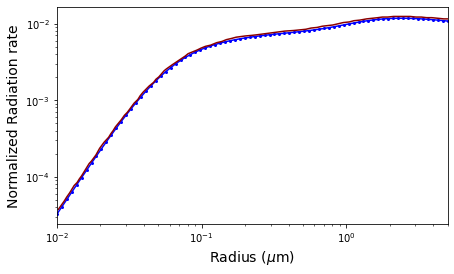

In [35]:
plt.figure(figsize = (7,4))
plt.loglog(radii*1e6, emphnew, '-o', c = 'blue', markersize = 2)
plt.loglog(x, y, c = 'darkred')
plt.xlabel(r'Radius ($\mu$m)', fontsize = 14)
plt.ylabel('Normalized Radiation rate',fontsize = 14)
plt.xlim(1e-2, 5)

In [27]:
file = open('Data_Krueger.dat', 'w')

for i in range(len(x)):
    file.write("%10.10e\t%10.10e\n"%(x[i], y[i]))

file.close()


In [26]:
file = open('Data_comparison.dat', 'w')

for i in range(len(radii)):
    file.write("%10.10e\t%10.10e\n"%(radii[i]*1e6, emphnew[i]))

file.close()